# Import Packages, Functions and Data

In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time



# Import custom version of titanlib containing changes
import titanlibcustom



# Import Formatted Data and functions from other Python script
from Data_Importation_and_Function_Definition import ROI_counties, NI_counties, rain_wow, rain_wow_hourly_obs, temp_wow, rain_official, temp_official, isolate_data_of_interest, plot_wow_data

Note: As advised, the Official Rainfall Rate column is currently beign set as equal to the 
Rainfall Accumulation Hourly column


# Obtain Test Data

In [2]:
gdf_temp_wow, gdf_temp_official, gdf_temp_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Temperature", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Air Temperature"])

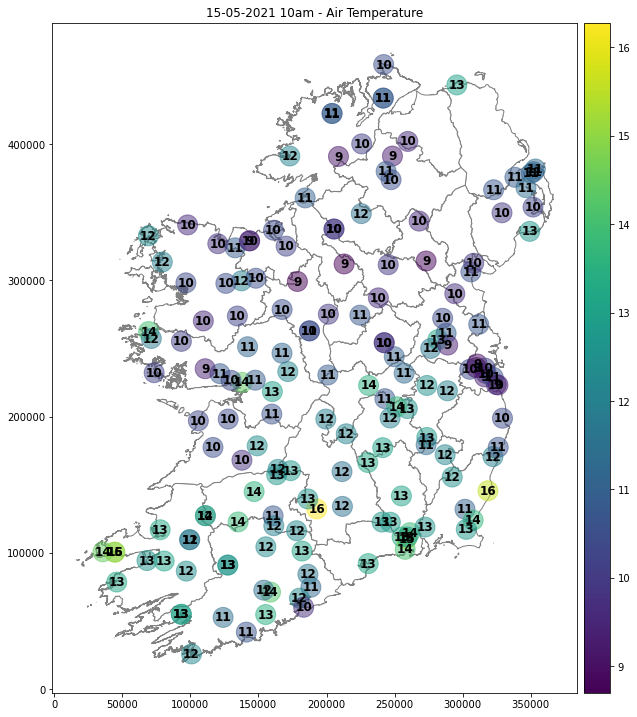

In [3]:
plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [4]:
# By default let's discard any missing data from Rainfall Accumulation, Rainfall Accumulation Hourly
# or Rainfall Rate.

# Note if we were only interested in one of these values we could maximise our data points by only
# removing missing values from the column of interest
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05",
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10",
                                                                              type_of_data="Rainfall", 
                                                                              add_elevation_bool=True,
                                                                              remove_missing_val=True, 
                                                                              cols_to_remove_missing_val=["Rainfall Accumulation", 
                                                                                                          "Rainfall Accumulation Hourly", 
                                                                                                          "Rainfall Rate"])

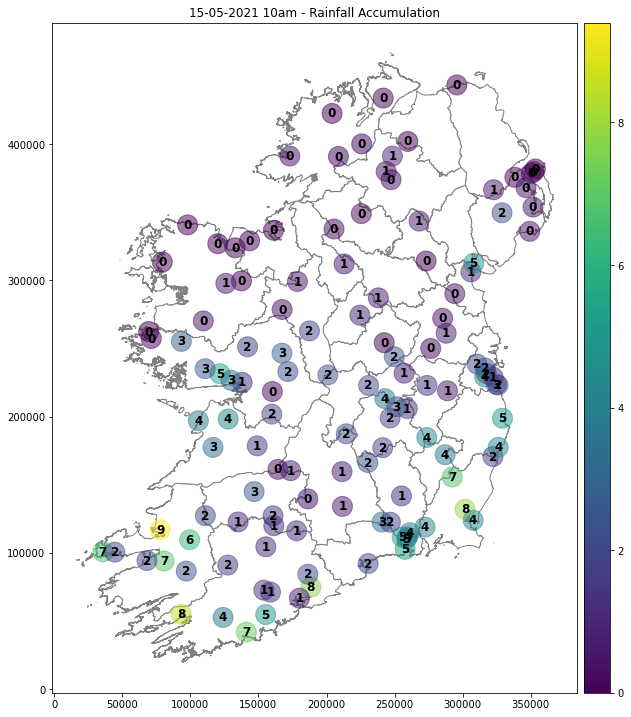

In [5]:
plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

# Buddy Checks

## Buddy Event Check

In [6]:
long_np = np.array(gdf_rain_combined["Longitude"])
lat_np = np.array(gdf_rain_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_rain_combined["Rainfall Accumulation"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 20000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 1) # Minimum number of neighbours for a valid test


event_threshold = 0.2 # Threshold above which the event is said to occur (i.e. rain happened)
threshold = 0.25 # Fraction of other observations in the neighbourhood that must agree with the obs being tested
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = 0 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations


flags = titanlib.buddy_event_check(points, np_values, radius, num_min, event_threshold, 
                                   threshold, max_elev_diff, elev_gradient, num_iterations)

flags

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

red: Stations that have been flagged as bad


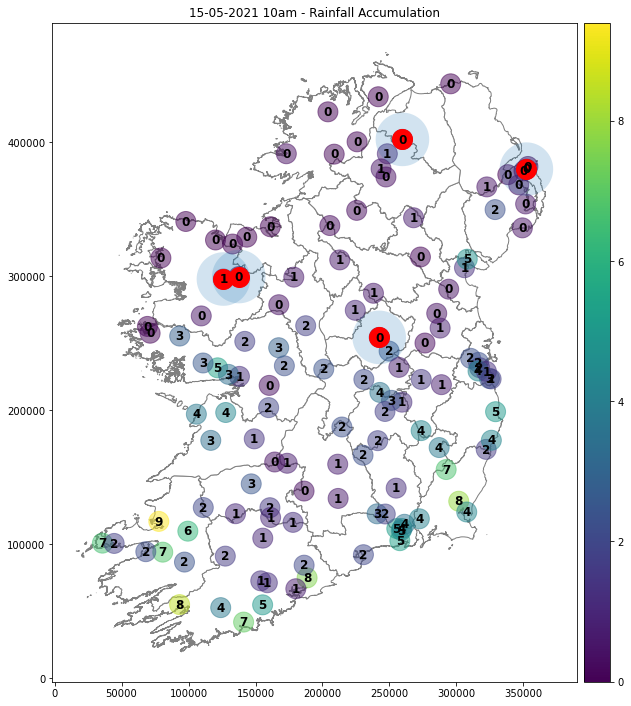

In [7]:
buffer_val_list = np.zeros(len(gdf_rain_combined), dtype = int)
indices = [i for i, x in enumerate(flags) if x == 1]
buffer_val_list[indices] = 20000
buffer_val_list = list(buffer_val_list)

plot_wow_data(gdf_of_interest = gdf_rain_combined, type_of_plot = "Rainfall Accumulation", 
              buffer_val = buffer_val_list, flags = flags)

## Buddy Check

In [8]:
long_np = np.array(gdf_temp_combined["Longitude"])
lat_np = np.array(gdf_temp_combined["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined["Air Temperature"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 40000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 5) # Minimum number of neighbours for a valid test (else throw an error)


# The buddy check flags an observations if |observation - avg of neighbours| normalized by the 
# standard deviation in the circle is greater than a predefined threshold

threshold = 3 # standard deviation threshold for flagging suspicious observations
min_std = 1 # If the sd of observations in the neighbourhood is less than this value use this instead as the check
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = -0.0065 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations

flags = titanlib.buddy_check(points, np_values, radius, num_min, threshold, 
                             max_elev_diff, elev_gradient, min_std, num_iterations)
flags

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

red: Stations that have been flagged as bad


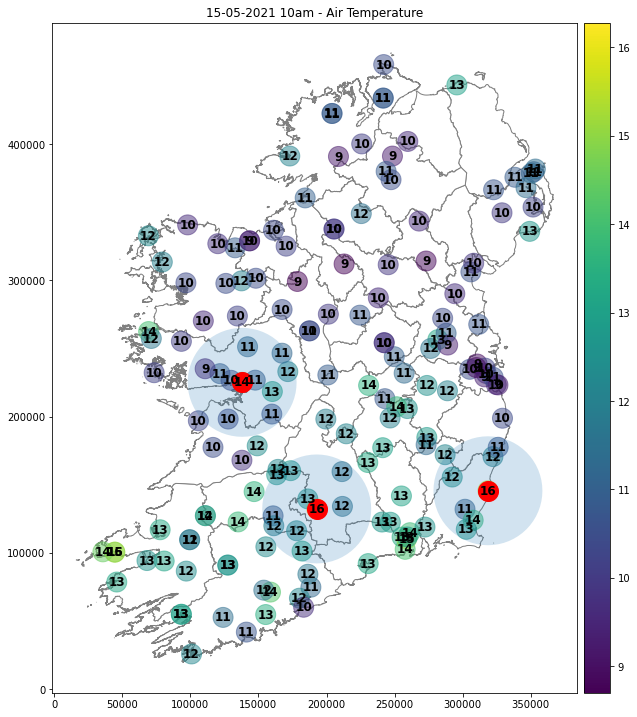

In [9]:
buffer_val_list = np.zeros(len(gdf_temp_combined), dtype = int)
indices = [i for i, x in enumerate(flags) if x == 1]
buffer_val_list[indices] = 40000
buffer_val_list = list(buffer_val_list)

plot_wow_data(gdf_of_interest = gdf_temp_combined, type_of_plot = "Air Temperature", 
              buffer_val = buffer_val_list, flags = flags)

## Induce outliers in test data to be flagged

In [10]:
# Create a data set with some outliers that will hopefully be flagged even with a high threshold

gdf_temp_combined_outliers = gdf_temp_combined.copy()

gdf_temp_combined_outliers.loc[gdf_temp_combined_outliers.index[[0, 1, 2, 3, 4]], ("Air Temperature")] = 30

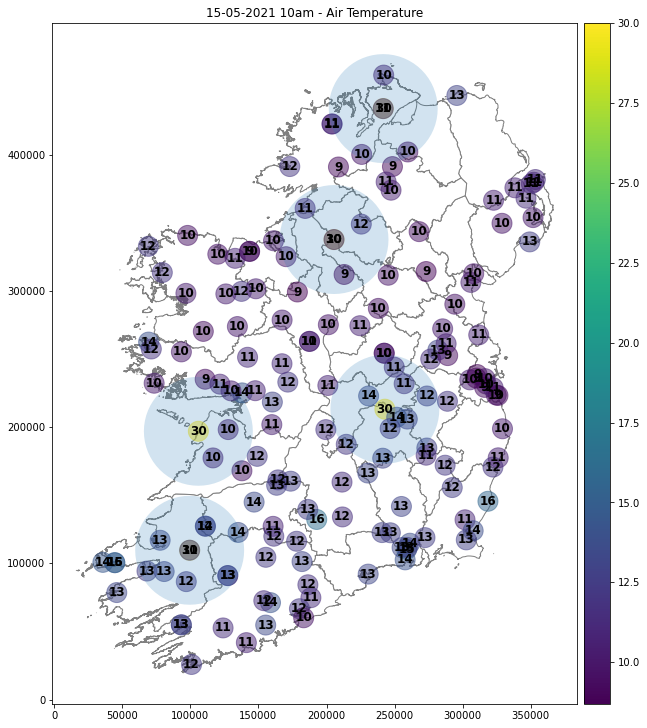

In [11]:
buffer_val_list = np.zeros(len(gdf_temp_combined_outliers), dtype = int)
outliers = [0, 1, 2, 3, 4]
buffer_val_list[outliers] = 40000
buffer_val_list = list(buffer_val_list)


plot_wow_data(gdf_of_interest = gdf_temp_combined_outliers, type_of_plot = "Air Temperature", 
              buffer_val = buffer_val_list, flags = None)

In [12]:
long_np = np.array(gdf_temp_combined_outliers["Longitude"])
lat_np = np.array(gdf_temp_combined_outliers["Latitude"])

points = titanlib.Points(lat_np, long_np) # Location of each station observation

np_values = np.array(gdf_temp_combined_outliers["Air Temperature"]) # Values you want to check Rainfall/Temp



# NOTE: the neighbourhood size I am using is almost certainly not suitable for a check like this
# as legitimate differences should probably be allowed to occur 10+ km away however this is just
# a proof of concept to get a feeling for how the check works

radius = np.full(points.size(), 40000) # Radius of neighbourhood of points to consider
num_min = np.full(points.size(), 5) # Minimum number of neighbours for a valid test (else throw an error)


# The buddy check flags an observations if |observation - avg of neighbours| normalized by the 
# standard deviation in the circle is greater than a predefined threshold

threshold = 5 # standard deviation threshold for flagging suspicious observations
min_std = 1 # If the sd of observations in the neighbourhood is less than this value use this instead as the check
max_elev_diff = 0 # Difference between elevations within the neighbourhood must not exceed this value
elev_gradient = -0.0065 # Value for linearly rescaling values for different elevations (e.g. for temp -0.0065 deg C per m)
num_iterations = 5 # Number of iterations



flags = titanlib.buddy_check(points, np_values, radius, num_min, threshold, 
                             max_elev_diff, elev_gradient, min_std, num_iterations)
flags

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

red: Stations that have been flagged as bad


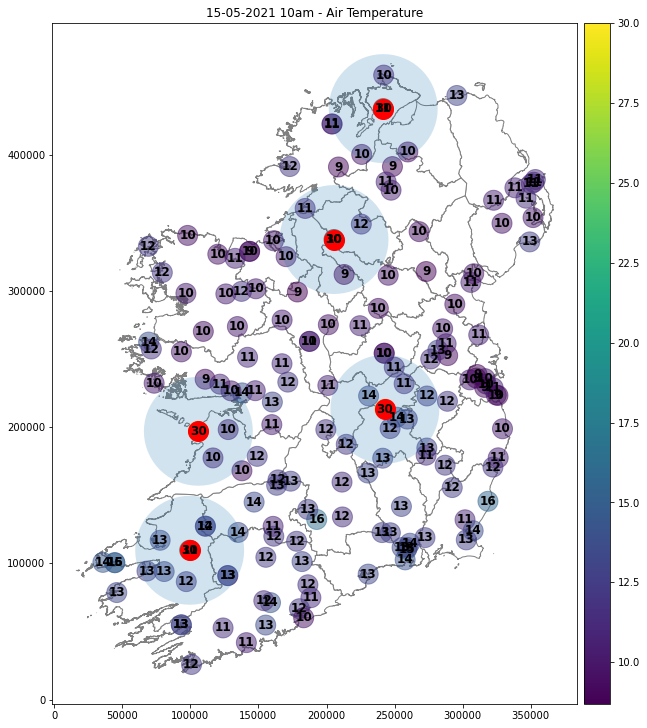

In [13]:
plot_wow_data(gdf_of_interest = gdf_temp_combined_outliers, type_of_plot = "Air Temperature", 
              buffer_val = buffer_val_list, flags = flags)